In [ ]:
import numpy as np
from scipy.optimize import fsolve
import pandas as pd

# Antoine constants (log10(P_mmHg) = A - B / (T_C + C))
A_eth, B_eth, C_eth = 8.20417, 1642.89, 230.300  # Ethanol
A_wat, B_wat, C_wat = 8.07131, 1730.63, 233.426  # Water

def Psat_ethanol(Tc):
    return 10 ** (A_eth - B_eth / (Tc + C_eth))

def Psat_water(Tc):
    return 10 ** (A_wat - B_wat / (Tc + C_wat))

# NRTL Parameters (tau_ij = a_ij + b_ij / T_K, alpha=0.3)
a12, b12 = -0.81, 246  # Ethanol(1)-Water(2)
a21, b21 = 3.46, -586
alpha = 0.3

def get_gammas(x1, Tk):
    x2 = 1 - x1
    tau12_ = a12 + b12 / Tk
    tau21_ = a21 + b21 / Tk
    G12 = np.exp(-alpha * tau12_)
    G21 = np.exp(-alpha * tau21_)
    gamma1 = np.exp(x2**2 * (tau21_ * (G21 / (x1 + x2 * G21))**2 + tau12_ * G12 / (x2 + x1 * G12)**2))
    gamma2 = np.exp(x1**2 * (tau12_ * (G12 / (x2 + x1 * G12))**2 + tau21_ * G21 / (x1 + x2 * G21)**2))
    return gamma1, gamma2

def bubble_T(x1, P_mmHg):
    def eq(Tc):
        Tk = Tc + 273.15
        gamma1, gamma2 = get_gammas(x1, Tk)
        return x1 * gamma1 * Psat_ethanol(Tc) + (1 - x1) * gamma2 * Psat_water(Tc) - P_mmHg

    # Improved initial guess: use Antoine equation for pure components or azeotrope
    if x1 == 0:
        T_guess = 100  # Water boiling point
    elif x1 == 1:
        T_guess = 78.3  # Ethanol boiling point
    else:
        # For mixtures, estimate based on pressure and composition
        T_guess = 78 + (100 - 78) * (1 - x1)  # Linear approximation
        # Adjust for pressure: lower P → lower T
        if P_mmHg < 760:
            T_guess -= (760 - P_mmHg) / 760 * 20  # Rough scaling
        elif P_mmHg > 760:
            T_guess += (P_mmHg - 760) / 760 * 10

    try:
        Tc = fsolve(eq, T_guess, xtol=1e-6, maxfev=1000)[0]
        # Check if solution is reasonable (e.g., 50°C < Tc < 150°C)
        if not 50 <= Tc <= 150:
            print(f"Warning: Tc={Tc:.2f}°C for x1={x1:.5f}, P={P_mmHg} mmHg is out of bounds. Using fallback.")
            Tc = T_guess  # Fallback to guess
        return np.round(Tc, 5)
    except Exception as e:
        print(f"fsolve failed for x1={x1:.5f}, P={P_mmHg} mmHg: {e}. Using T_guess.")
        return np.round(T_guess, 5)

# Generate data
P_mmHg_list = [200, 400, 760, 1000, 1500]  # ~0.26 to ~2 atm
x_base = np.round(np.concatenate([np.linspace(0, 0.7, 30), np.linspace(0.7, 0.95, 50), np.linspace(0.95, 1, 20)]), 5)

data = []
for P_mmHg in P_mmHg_list:
    for x1 in x_base:
        if x1 == 0 or x1 == 1:
            Tc = 100 if x1 == 0 else 78.3
            y1 = x1
        else:
            Tc = bubble_T(x1, P_mmHg)
            Tk = Tc + 273.15
            gamma1, _ = get_gammas(x1, Tk)
            y1 = x1 * gamma1 * Psat_ethanol(Tc) / P_mmHg
        P_atm = P_mmHg / 760
        # Round all values to 5 decimal places for final output
        x1 = np.round(x1, 5)
        Tk = np.round(Tk, 5)
        P_atm = np.round(P_atm, 5)
        y1 = np.round(y1, 5)
        data.append([x1, Tk, P_atm, y1])
        print(f"Data point: [x1={x1:.5f}, Tk={Tk:.5f}, P_atm={P_atm:.5f}, y1={y1:.5f}]")  # Debug

df = pd.DataFrame(data, columns=['x1', 'T', 'P', 'y1'])
df = df.astype(float)  # Ensure all numeric
print("DataFrame head:\n", df.head())
print("DataFrame dtypes:\n", df.dtypes)
df.to_csv('vle_data1.csv', index=False)
print(f"Generated {len(df)} data points. Saved to vle_data.csv")

Data point: [x1=0.00000, Tk=351.45000, P_atm=0.26316, y1=0.00000]
Data point: [x1=0.02414, Tk=335.00304, P_atm=0.26316, y1=0.20686]
Data point: [x1=0.04828, Tk=332.10414, P_atm=0.26316, y1=0.32035]
Data point: [x1=0.07241, Tk=330.13077, P_atm=0.26316, y1=0.39194]
Data point: [x1=0.09655, Tk=328.71196, P_atm=0.26316, y1=0.44118]
Data point: [x1=0.12069, Tk=327.65248, P_atm=0.26316, y1=0.47710]
Data point: [x1=0.14483, Tk=326.83702, P_atm=0.26316, y1=0.50452]
Data point: [x1=0.16897, Tk=326.19294, P_atm=0.26316, y1=0.52626]
Data point: [x1=0.19310, Tk=325.67235, P_atm=0.26316, y1=0.54403]
Data point: [x1=0.21724, Tk=325.24186, P_atm=0.26316, y1=0.55902]
Data point: [x1=0.24138, Tk=324.87843, P_atm=0.26316, y1=0.57200]
Data point: [x1=0.26552, Tk=324.56536, P_atm=0.26316, y1=0.58353]
Data point: [x1=0.28966, Tk=324.29046, P_atm=0.26316, y1=0.59401]
Data point: [x1=0.31379, Tk=324.04482, P_atm=0.26316, y1=0.60376]
Data point: [x1=0.33793, Tk=323.82160, P_atm=0.26316, y1=0.61300]
Data point

BINARY VLE ANN SURROGATE MODEL
Configuration:
  Epochs: 200
  Batch size: 32
  Learning rate: 0.001
  Early stopping patience: 20
  Scaler type: standard
Loading data from vle_data.csv
Dataset loaded successfully with 500 samples
Dataset shape: (500, 4)

First 5 rows:
        x1          T        P       y1
0  0.00000  351.45000  0.26316  0.00000
1  0.02414  335.00304  0.26316  0.20686
2  0.04828  332.10414  0.26316  0.32035
3  0.07241  330.13077  0.26316  0.39194
4  0.09655  328.71196  0.26316  0.44118

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      500 non-null    float64
 1   T       500 non-null    float64
 2   P       500 non-null    float64
 3   y1      500 non-null    float64
dtypes: float64(4)
memory usage: 15.8 KB
None

Dataset statistics:
               x1           T           P          y1
count  500.000000  500.000000

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,897 (66.00 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)


Parameter counts:
  Trainable parameters: 16,897
  Non-trainable parameters: 0
  Total parameters: 16,897

=== TRAINING MODEL ===
Training parameters: epochs=200, batch_size=32, patience=20
Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.1053 - mae: 0.2898 - rmse: 0.3215
Epoch 1: val_loss improved from inf to 0.04959, saving model to best_model.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 0.1037 - mae: 0.2874 - rmse: 0.3192 - val_loss: 0.0496 - val_mae: 0.1956 - val_rmse: 0.2360
Epoch 2/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - loss: 0.0449 - mae: 0.1790 - rmse: 0.2520
Epoch 2: val_loss improved from 0.04959 to 0.01741, saving model to best_model.weights.h5
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0334 - mae: 0.1521 - rmse: 0.2281 - val_loss: 0.0174 - val_mae: 0.1064 - val_rmse: 0.2168
Epoch 3/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0177 - mae: 0.1011 - rmse: 0.2657
Epoch 3: val_loss improved from 0.01741 to 0.00795, saving mode

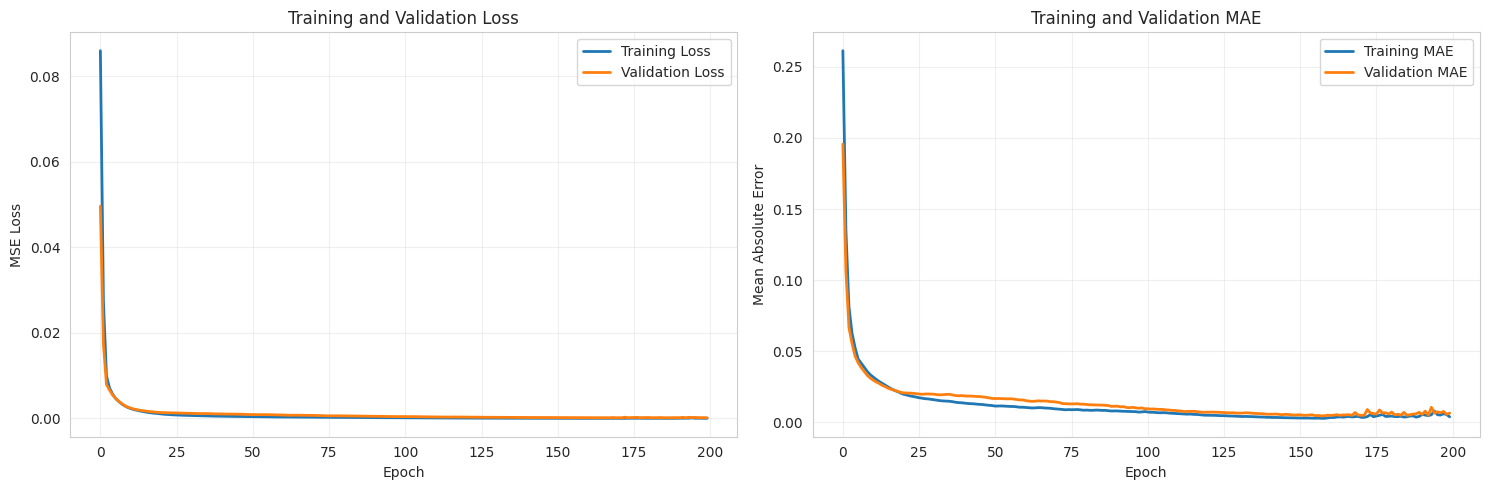


=== SAVING MODEL AND PIPELINE ===
Model saved as 'ann_vle_model.h5'
Preprocessing pipeline saved as 'preprocessing_pipeline.pkl'

=== MODEL EVALUATION ===
Test Set Metrics:
  MAE: 0.009789
  RMSE: 0.044143
  MAPE: 49621316.81%
Creating evaluation plots...


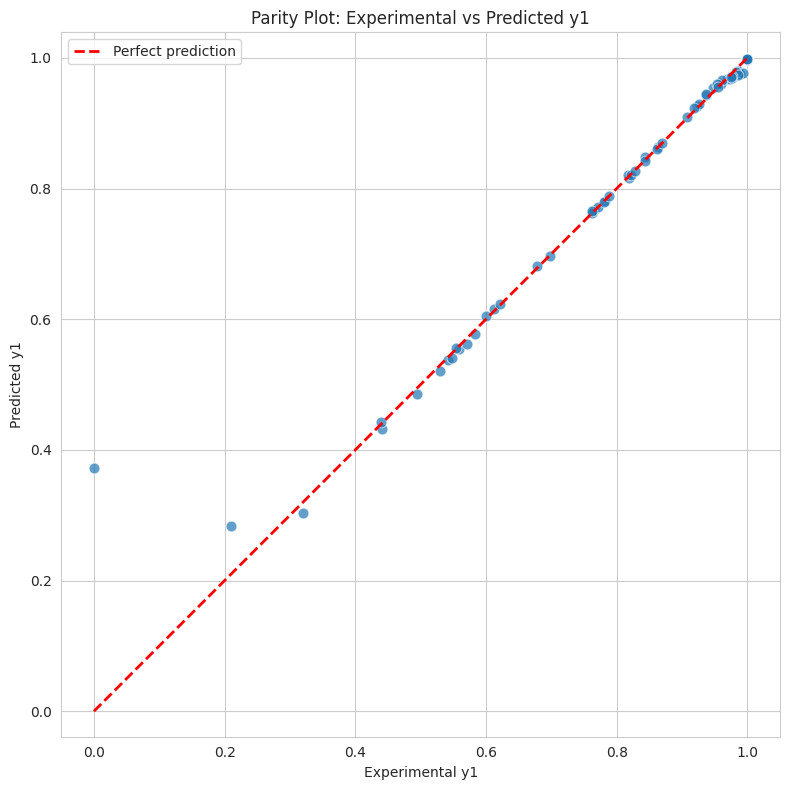

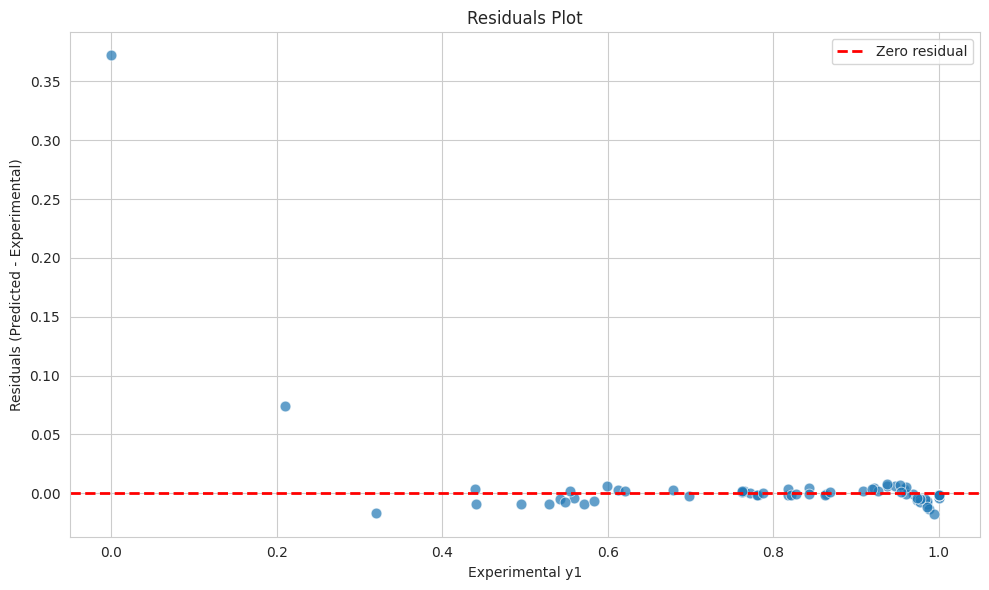

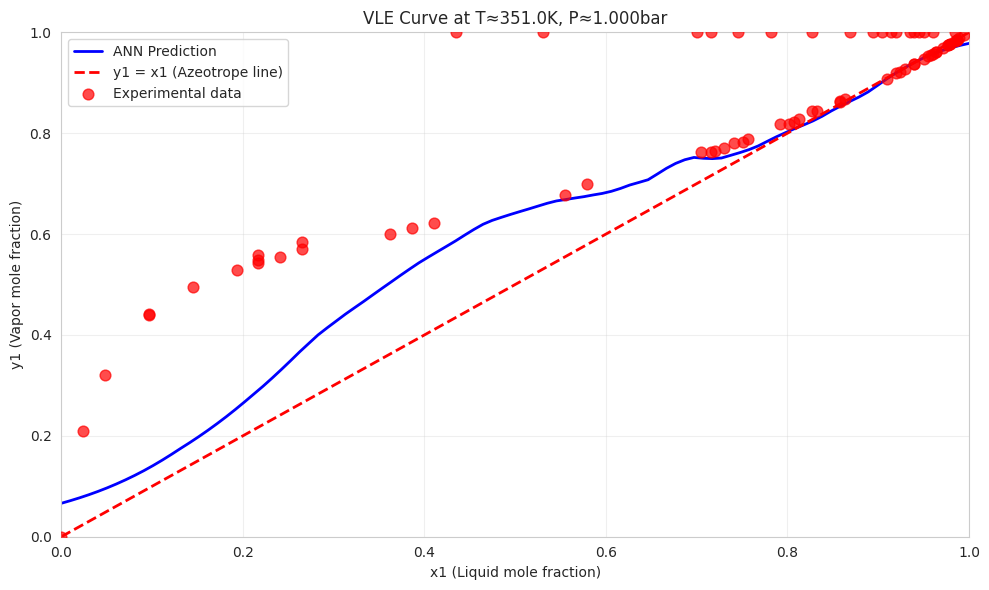


=== AZEOTROPE DETECTION ===
Method 1: Grid scan approach
  Grid scan results:
    Minimum |y1 - x1| = 0.000019
    x1_azeotrope = 0.8124
    y1_predicted = 0.8124
    T_azeotrope = 350.98 K
    P = 1.0000 bar
    Azeotrope detected: True
Method 2: Root-finding approach


  Root-finding results:
    Root found successfully
    x1_azeotrope = 0.812371
    y1_azeotrope = 0.812371
    |y1 - x1| = 0.000000
    T_azeotrope = 350.98 K
    P = 1.0000 bar
    Azeotrope detected: True

=== RAOULT'S LAW BASELINE ===
Using simplified Raoult's law with estimated saturation pressures
Note: This is a demonstration baseline - real implementation would need vapor pressure data
Baseline Metrics (Simplified Raoult's Law):
  MAE: 0.093034
  RMSE: 0.136006


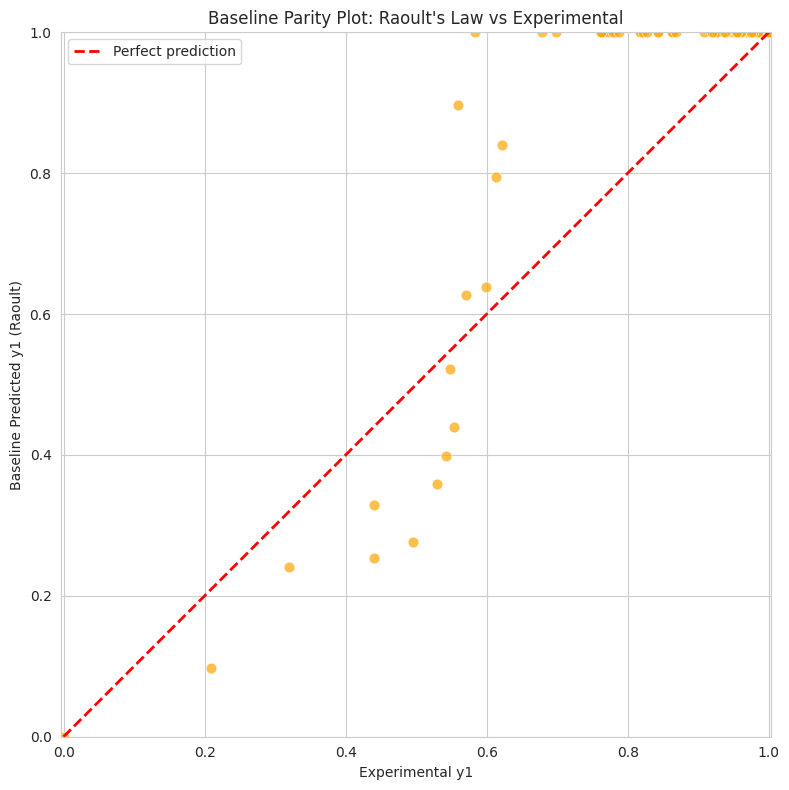


=== DEMONSTRATING SAVED MODEL USAGE ===

=== LOADING SAVED MODEL FOR PREDICTION ===
Error in prediction: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

Example: Dense grid prediction for azeotrope detection

=== LOADING SAVED MODEL FOR PREDICTION ===
Error in prediction: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

=== CREATING RESULTS ZIP FILE ===
Added ann_vle_model.h5 to zip
Added preprocessing_pipeline.pkl to zip
Added parity_plot.png to zip
Added residuals_plot.png to zip
Added y_vs_x_plot.png to zip
Added training_history.png to zip
Added baseline_parity_plot.png to zip
Results packaged in ANN_

In [ ]:
# Binary VLE ANN Surrogate Model
# Required pip installs: tensorflow scikit-learn pandas seaborn matplotlib joblib scipy numpy

import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import zipfile
from io import StringIO
from scipy.optimize import brentq
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure seaborn style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

def load_data(csv_filepath='vle_data.csv'):
    """
    Load VLE data from CSV file or use embedded sample data.

    Parameters:
    csv_filepath (str): Path to CSV file

    Returns:
    pandas.DataFrame: Loaded VLE data
    """
    
    if os.path.exists(csv_filepath):
        print(f"Loading data from {csv_filepath}")
        df = pd.read_csv(csv_filepath)
    else:
        print("Data is not present at path :",csv_filepath)

    print(f"Dataset loaded successfully with {len(df)} samples")
    print(f"Dataset shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print(f"\nDataset info:")
    print(df.info())
    print(f"\nDataset statistics:")
    print(df.describe())

    return df

def preprocess_data(df, scaler_type='standard'):
    """
    Preprocess the VLE data with scaling options.

    Parameters:
    df (pandas.DataFrame): Input data
    scaler_type (str): 'standard' or 'minmax'

    Returns:
    dict: Preprocessed data and scaler objects
    """
    print(f"\n=== PREPROCESSING WITH {scaler_type.upper()} SCALING ===")

    # Separate features and target
    X = df[['x1', 'T', 'P']].values
    y = df['y1'].values

    # Clip target to physical bounds [0,1]
    y = np.clip(y, 0, 1)
    print(f"Target y1 clipped to [0,1]: min={y.min():.4f}, max={y.max():.4f}")

    # Choose scaler
    if scaler_type == 'standard':
        scaler = StandardScaler()
        print("Using StandardScaler for input features")
    else:
        scaler = MinMaxScaler()
        print("Using MinMaxScaler for input features")

    # Fit and transform features
    X_scaled = scaler.fit_transform(X)

    print(f"Original features - X shape: {X.shape}")
    print(f"Scaled features - X_scaled shape: {X_scaled.shape}")
    print(f"Original feature ranges:")
    for i, col in enumerate(['x1', 'T', 'P']):
        print(f"  {col}: [{X[:, i].min():.4f}, {X[:, i].max():.4f}]")
    print(f"Scaled feature ranges:")
    for i, col in enumerate(['x1', 'T', 'P']):
        print(f"  {col}: [{X_scaled[:, i].min():.4f}, {X_scaled[:, i].max():.4f}]")

    # Create preprocessing pipeline
    preprocessing_pipeline = {
        'scaler': scaler,
        'scaler_type': scaler_type,
        'feature_names': ['x1', 'T', 'P'],
        'target_name': 'y1'
    }

    return {
        'X_scaled': X_scaled,
        'y': y,
        'X_raw': X,
        'preprocessing_pipeline': preprocessing_pipeline
    }

def split_data(X_scaled, y, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split data into train/validation/test sets.

    Parameters:
    X_scaled (numpy.array): Scaled input features
    y (numpy.array): Target values
    test_size (float): Test set fraction
    val_size (float): Validation set fraction
    random_state (int): Random state for reproducibility

    Returns:
    dict: Split datasets
    """
    print(f"\n=== DATA SPLITTING ===")

    # Check if dataset is too small
    n_samples = len(X_scaled)
    if n_samples < 10:
        print(f"WARNING: Dataset is very small ({n_samples} samples). Consider using more data for robust training.")

    # First split: separate test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=test_size, random_state=random_state, shuffle=True
    )

    # Second split: separate train and validation from remaining data
    val_size_adjusted = val_size / (1 - test_size)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, shuffle=True
    )

    print(f"Data split completed:")
    print(f"  Training set: {len(X_train)} samples ({len(X_train)/n_samples*100:.1f}%)")
    print(f"  Validation set: {len(X_val)} samples ({len(X_val)/n_samples*100:.1f}%)")
    print(f"  Test set: {len(X_test)} samples ({len(X_test)/n_samples*100:.1f}%)")

    return {
        'X_train': X_train, 'X_val': X_val, 'X_test': X_test,
        'y_train': y_train, 'y_val': y_val, 'y_test': y_test
    }

def build_model(input_shape, learning_rate=0.001):
    """
    Build the ANN model architecture.

    Parameters:
    input_shape (tuple): Shape of input features
    learning_rate (float): Learning rate for Adam optimizer

    Returns:
    tensorflow.keras.Model: Compiled model
    """
    print(f"\n=== BUILDING MODEL ===")

    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(64, activation='relu', name='hidden_1'),
        layers.Dense(128, activation='relu', name='hidden_2'),
        layers.Dense(64, activation='relu', name='hidden_3'),
        layers.Dense(1, activation='sigmoid', name='output')  # Sigmoid to ensure [0,1]
    ])

    # Custom RMSE metric
    def rmse(y_true, y_pred):
        return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', rmse]
    )

    print("Model architecture:")
    model.summary()

    # Count parameters
    trainable_params = model.count_params()
    non_trainable_params = sum([tf.reduce_prod(var.shape) for var in model.non_trainable_variables])

    print(f"\nParameter counts:")
    print(f"  Trainable parameters: {trainable_params:,}")
    print(f"  Non-trainable parameters: {non_trainable_params:,}")
    print(f"  Total parameters: {trainable_params + non_trainable_params:,}")

    return model

def train_model(model, data_splits, epochs=200, batch_size=32, patience=20):
    """
    Train the ANN model.

    Parameters:
    model: Keras model
    data_splits (dict): Training, validation, test data
    epochs (int): Maximum number of epochs
    batch_size (int): Batch size
    patience (int): Early stopping patience

    Returns:
    tuple: (trained_model, history)
    """
    print(f"\n=== TRAINING MODEL ===")
    print(f"Training parameters: epochs={epochs}, batch_size={batch_size}, patience={patience}")

    # Setup callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model.weights.h5',
            monitor='val_loss',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        )
    ]

    # Train model
    history = model.fit(
        data_splits['X_train'], data_splits['y_train'],
        validation_data=(data_splits['X_val'], data_splits['y_val']),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    print(f"Training completed after {len(history.history['loss'])} epochs")

    return model, history

def evaluate_model(model, data_splits, preprocessing_pipeline):
    """
    Evaluate the trained model and create visualizations.

    Parameters:
    model: Trained Keras model
    data_splits (dict): Data splits
    preprocessing_pipeline (dict): Preprocessing objects

    Returns:
    dict: Evaluation metrics
    """
    print(f"\n=== MODEL EVALUATION ===")

    # Make predictions on test set
    y_test_pred = model.predict(data_splits['X_test'], verbose=0).flatten()
    y_test_true = data_splits['y_test']

    # Ensure predictions are in [0,1]
    y_test_pred = np.clip(y_test_pred, 0, 1)

    # Calculate metrics
    mae = mean_absolute_error(y_test_true, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mape = np.mean(np.abs((y_test_true - y_test_pred) / (y_test_true + 1e-8))) * 100

    print(f"Test Set Metrics:")
    print(f"  MAE: {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.2f}%")

    # Create plots
    create_evaluation_plots(model, data_splits, preprocessing_pipeline, y_test_true, y_test_pred)

    return {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'y_test_true': y_test_true,
        'y_test_pred': y_test_pred
    }

def create_evaluation_plots(model, data_splits, preprocessing_pipeline, y_test_true, y_test_pred):
    """Create evaluation plots using seaborn."""
    print("Creating evaluation plots...")

    # 1. Parity plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test_true, y=y_test_pred, alpha=0.7, s=60)
    # 45-degree line
    min_val, max_val = min(y_test_true.min(), y_test_pred.min()), max(y_test_true.max(), y_test_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('Experimental y1')
    plt.ylabel('Predicted y1')
    plt.title('Parity Plot: Experimental vs Predicted y1')
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('parity_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Residuals plot
    residuals = y_test_pred - y_test_true
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test_true, y=residuals, alpha=0.7, s=60)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero residual')
    plt.xlabel('Experimental y1')
    plt.ylabel('Residuals (Predicted - Experimental)')
    plt.title('Residuals Plot')
    plt.legend()
    plt.tight_layout()
    plt.savefig('residuals_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. y1 vs x1 curve (for fixed P)
    create_y_vs_x_plot(model, data_splits, preprocessing_pipeline)

    # 4. Training history plots
    # Note: This will be called separately after training with history object

def create_y_vs_x_plot(model, data_splits, preprocessing_pipeline):
    """Create y1 vs x1 plot for fixed P."""

    # Get original data ranges for plotting
    scaler = preprocessing_pipeline['scaler']

    # Create dense x1 grid
    x1_grid = np.linspace(0, 1, 100)

    # Get original data from training set to determine representative T and P
    temp_inverse = scaler.inverse_transform(data_splits['X_train'])
    T_mean_original = np.mean(temp_inverse[:, 1])
    P_original = temp_inverse[0, 2]  # Assuming constant pressure

    # Create grid in original space then scale
    X_grid_original = np.column_stack([
        x1_grid,
        T_mean_original * np.ones_like(x1_grid),
        P_original * np.ones_like(x1_grid)
    ])
    X_grid_scaled = scaler.transform(X_grid_original)

    # Predict
    y_pred_grid = model.predict(X_grid_scaled, verbose=0).flatten()
    y_pred_grid = np.clip(y_pred_grid, 0, 1)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(x1_grid, y_pred_grid, 'b-', linewidth=2, label='ANN Prediction')
    plt.plot(x1_grid, x1_grid, 'r--', linewidth=2, label='y1 = x1 (Azeotrope line)')

    # Overlay experimental data
    X_test_original = scaler.inverse_transform(data_splits['X_test'])
    plt.scatter(X_test_original[:, 0], data_splits['y_test'],
                color='red', s=60, alpha=0.7, label='Experimental data', zorder=5)

    plt.xlabel('x1 (Liquid mole fraction)')
    plt.ylabel('y1 (Vapor mole fraction)')
    plt.title(f'VLE Curve at T≈{T_mean_original:.1f}K, P≈{P_original:.3f}bar')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('y_vs_x_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_training_history(history):
    """Plot training history."""
    print("Creating training history plots...")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # MAE plot
    ax2.plot(history.history['mae'], label='Training MAE', linewidth=2)
    ax2.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.set_title('Training and Validation MAE')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def detect_azeotrope(model, preprocessing_pipeline, data_splits, method='both'):
    """
    Detect azeotrope using the trained ANN.

    Parameters:
    model: Trained Keras model
    preprocessing_pipeline (dict): Preprocessing objects
    data_splits (dict): Data splits
    method (str): 'grid', 'root', or 'both'

    Returns:
    dict: Azeotrope detection results
    """
    print(f"\n=== AZEOTROPE DETECTION ===")

    scaler = preprocessing_pipeline['scaler']

    # Get representative T and P from training data
    X_train_original = scaler.inverse_transform(data_splits['X_train'])
    T_mean = np.mean(X_train_original[:, 1])
    P_fixed = X_train_original[0, 2]  # Assuming constant pressure

    results = {}

    if method in ['grid', 'both']:
        print("Method 1: Grid scan approach")
        results['grid'] = grid_scan_azeotrope(model, scaler, T_mean, P_fixed)

    if method in ['root', 'both']:
        print("Method 2: Root-finding approach")
        results['root'] = root_finding_azeotrope(model, scaler, T_mean, P_fixed)

    return results

def grid_scan_azeotrope(model, scaler, T_fixed, P_fixed):
    """Grid scan method for azeotrope detection."""

    # Create dense grid
    x1_grid = np.linspace(0.01, 0.99, 1000)  # Avoid exact 0 and 1

    # Prepare input for prediction
    X_grid_original = np.column_stack([
        x1_grid,
        T_fixed * np.ones_like(x1_grid),
        P_fixed * np.ones_like(x1_grid)
    ])
    X_grid_scaled = scaler.transform(X_grid_original)

    # Predict y1
    y1_pred = model.predict(X_grid_scaled, verbose=0).flatten()
    y1_pred = np.clip(y1_pred, 0, 1)

    # Find where |y1 - x1| is minimum
    diff = np.abs(y1_pred - x1_grid)
    min_idx = np.argmin(diff)

    x1_azeotrope = x1_grid[min_idx]
    y1_azeotrope = y1_pred[min_idx]
    min_difference = diff[min_idx]

    print(f"  Grid scan results:")
    print(f"    Minimum |y1 - x1| = {min_difference:.6f}")
    print(f"    x1_azeotrope = {x1_azeotrope:.4f}")
    print(f"    y1_predicted = {y1_azeotrope:.4f}")
    print(f"    T_azeotrope = {T_fixed:.2f} K")
    print(f"    P = {P_fixed:.4f} bar")

    # Check if this is a reasonable azeotrope (difference should be small)
    is_azeotrope = min_difference < 0.05  # 5% tolerance
    print(f"    Azeotrope detected: {is_azeotrope}")

    return {
        'x1_azeotrope': x1_azeotrope,
        'y1_azeotrope': y1_azeotrope,
        'T_azeotrope': T_fixed,
        'P': P_fixed,
        'min_difference': min_difference,
        'is_azeotrope': is_azeotrope,
        'x1_grid': x1_grid,
        'y1_pred': y1_pred
    }

def root_finding_azeotrope(model, scaler, T_fixed, P_fixed):
    """Root-finding method for azeotrope detection."""

    def objective_function(x1):
        """Objective function: y1_pred(x1) - x1 = 0"""
        X_input = np.array([[x1, T_fixed, P_fixed]])
        X_scaled = scaler.transform(X_input)
        y1_pred = model.predict(X_scaled, verbose=0)[0, 0]
        y1_pred = np.clip(y1_pred, 0, 1)
        return y1_pred - x1

    try:
        # Try to find root using Brent's method
        # First, check if there's a sign change
        x1_test = np.linspace(0.01, 0.99, 100)
        obj_vals = [objective_function(x) for x in x1_test]

        # Find sign changes
        sign_changes = []
        for i in range(len(obj_vals)-1):
            if obj_vals[i] * obj_vals[i+1] < 0:
                sign_changes.append((x1_test[i], x1_test[i+1]))

        if sign_changes:
            # Use the first sign change
            a, b = sign_changes[0]
            x1_azeotrope = brentq(objective_function, a, b, xtol=1e-6)

            # Get corresponding y1
            X_input = np.array([[x1_azeotrope, T_fixed, P_fixed]])
            X_scaled = scaler.transform(X_input)
            y1_azeotrope = model.predict(X_scaled, verbose=0)[0, 0]
            y1_azeotrope = np.clip(y1_azeotrope, 0, 1)

            difference = abs(y1_azeotrope - x1_azeotrope)

            print(f"  Root-finding results:")
            print(f"    Root found successfully")
            print(f"    x1_azeotrope = {x1_azeotrope:.6f}")
            print(f"    y1_azeotrope = {y1_azeotrope:.6f}")
            print(f"    |y1 - x1| = {difference:.6f}")
            print(f"    T_azeotrope = {T_fixed:.2f} K")
            print(f"    P = {P_fixed:.4f} bar")

            is_azeotrope = difference < 0.01
            print(f"    Azeotrope detected: {is_azeotrope}")

            return {
                'x1_azeotrope': x1_azeotrope,
                'y1_azeotrope': y1_azeotrope,
                'T_azeotrope': T_fixed,
                'P': P_fixed,
                'difference': difference,
                'is_azeotrope': is_azeotrope,
                'method_success': True
            }
        else:
            print(f"  Root-finding results: No sign change found in objective function")
            return {'method_success': False, 'reason': 'No sign change'}

    except Exception as e:
        print(f"  Root-finding failed: {e}")
        return {'method_success': False, 'reason': str(e)}

def implement_raoult_baseline(data_splits, preprocessing_pipeline):
    """
    Implement Raoult's Law baseline for comparison.
    """
    print(f"\n=== RAOULT'S LAW BASELINE ===")

    scaler = preprocessing_pipeline['scaler']
    X_test_original = scaler.inverse_transform(data_splits['X_test'])

    # Simple baseline: assume ideal behavior with estimated saturation pressures
    # This is a mock implementation since we don't have Antoine coefficients
    print("Using simplified Raoult's law with estimated saturation pressures")
    print("Note: This is a demonstration baseline - real implementation would need vapor pressure data")

    # Mock saturation pressures (these would normally come from Antoine equation)
    # For demo purposes, estimate based on typical behavior
    def estimate_psat(T, component='light'):
        """Mock saturation pressure estimation"""
        if component == 'light':
            # Lighter component (lower boiling point)
            return 0.5 * np.exp(10 - 3000/T)
        else:
            # Heavier component (higher boiling point)
            return 0.3 * np.exp(8 - 2500/T)

    # Calculate baseline predictions
    x1_test = X_test_original[:, 0]
    T_test = X_test_original[:, 1]
    P_test = X_test_original[:, 2]

    P_sat1 = estimate_psat(T_test, 'light')
    P_sat2 = estimate_psat(T_test, 'heavy')

    # Raoult's law: y1 = (x1 * P_sat1) / P_total
    y1_baseline = (x1_test * P_sat1) / P_test
    y1_baseline = np.clip(y1_baseline, 0, 1)

    # Calculate baseline metrics
    y_test_true = data_splits['y_test']
    mae_baseline = mean_absolute_error(y_test_true, y1_baseline)
    rmse_baseline = np.sqrt(mean_squared_error(y_test_true, y1_baseline))

    print(f"Baseline Metrics (Simplified Raoult's Law):")
    print(f"  MAE: {mae_baseline:.6f}")
    print(f"  RMSE: {rmse_baseline:.6f}")

    # Create baseline parity plot
    plt.figure(figsize=(8, 8))
    sns.scatterplot(x=y_test_true, y=y1_baseline, alpha=0.7, s=60, color='orange')
    min_val, max_val = 0, 1
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    plt.xlabel('Experimental y1')
    plt.ylabel('Baseline Predicted y1 (Raoult)')
    plt.title('Baseline Parity Plot: Raoult\'s Law vs Experimental')
    plt.legend()
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig('baseline_parity_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {
        'mae_baseline': mae_baseline,
        'rmse_baseline': rmse_baseline,
        'y1_baseline': y1_baseline
    }

def save_artifacts(model, preprocessing_pipeline):
    """Save model and preprocessing pipeline."""
    print(f"\n=== SAVING MODEL AND PIPELINE ===")

    # Save Keras model
    model.save('ann_vle_model.h5')
    print("Model saved as 'ann_vle_model.h5'")

    # Save preprocessing pipeline
    joblib.dump(preprocessing_pipeline, 'preprocessing_pipeline.pkl')
    print("Preprocessing pipeline saved as 'preprocessing_pipeline.pkl'")

def predict_from_saved(X_raw, model_path='ann_vle_model.h5', pipeline_path='preprocessing_pipeline.pkl'):
    """
    Load saved artifacts and make predictions.

    Parameters:
    X_raw (numpy.array): Raw input features [x1, T, P]
    model_path (str): Path to saved model
    pipeline_path (str): Path to saved preprocessing pipeline

    Returns:
    numpy.array: Predicted y1 values
    """
    print(f"\n=== LOADING SAVED MODEL FOR PREDICTION ===")

    try:
        # Load model and pipeline
        model = keras.models.load_model(model_path)
        preprocessing_pipeline = joblib.load(pipeline_path)
        print(f"Loaded model from {model_path}")
        print(f"Loaded pipeline from {pipeline_path}")

        # Ensure X_raw is 2D
        if X_raw.ndim == 1:
            X_raw = X_raw.reshape(1, -1)

        # Apply preprocessing
        scaler = preprocessing_pipeline['scaler']
        X_scaled = scaler.transform(X_raw)

        # Make predictions
        y_pred = model.predict(X_scaled, verbose=0).flatten()
        y_pred = np.clip(y_pred, 0, 1)  # Ensure [0,1] bounds

        print(f"Made predictions for {len(X_raw)} samples")
        return y_pred

    except Exception as e:
        print(f"Error in prediction: {e}")
        return None

def create_results_zip():
    """Create a zip file with all results."""
    print(f"\n=== CREATING RESULTS ZIP FILE ===")

    files_to_zip = [
        'ann_vle_model.h5',
        'preprocessing_pipeline.pkl',
        'best_model_weights.h5',
        'parity_plot.png',
        'residuals_plot.png',
        'y_vs_x_plot.png',
        'training_history.png',
        'baseline_parity_plot.png'
    ]

    zip_filename = 'ANN_BinaryVLE.zip'

    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in files_to_zip:
            if os.path.exists(file):
                zipf.write(file)
                print(f"Added {file} to zip")
            else:
                print(f"Warning: {file} not found, skipping")

    print(f"Results packaged in {zip_filename}")
    return zip_filename

def print_final_instructions():
    """Print instructions for report generation and sharing."""
    print(f"\n" + "="*60)
    print("FINAL INSTRUCTIONS")
    print("="*60)

    print("\n1. GENERATE PDF REPORT:")
    print("   Create a 2-3 page PDF report including:")
    print("   - Brief methodology description")
    print("   - Model architecture and parameters")
    print("   - Training results and metrics")
    print("   - All generated plots")
    print("   - Azeotrope detection results")
    print("   - Comparison with baseline")
    print("   - Conclusions and recommendations")

    print("\n2. ZIP FILE CREATION:")
    print("   A zip file 'ANN_BinaryVLE.zip' has been created containing:")
    print("   - Trained model (ann_vle_model.h5)")
    print("   - Preprocessing pipeline (preprocessing_pipeline.pkl)")
    print("   - All generated plots (PNG files)")
    print("   - Best model weights")

    print("\n3. GOOGLE DRIVE SHARING:")
    print("   To share via Google Drive:")
    print("   a) Upload ANN_BinaryVLE.zip to your Google Drive")
    print("   b) Right-click the file → 'Get link'")
    print("   c) Set permissions to 'Anyone with the link can view'")
    print("   d) Copy the shareable link")

    print("\n4. FILES GENERATED:")
    print("   - ann_vle_model.h5 (trained model)")
    print("   - preprocessing_pipeline.pkl (scalers)")
    print("   - best_model_weights.weights.h5 (best weights)")
    print("   - parity_plot.png")
    print("   - residuals_plot.png")
    print("   - y_vs_x_plot.png")
    print("   - training_history.png")
    print("   - baseline_parity_plot.png")
    print("   - ANN_BinaryVLE.zip (complete package)")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("BINARY VLE ANN SURROGATE MODEL")
    print("="*60)

    # User-configurable parameters
    EPOCHS = 200
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    PATIENCE = 20
    SCALER_TYPE = 'standard'  # 'standard' or 'minmax'

    print(f"Configuration:")
    print(f"  Epochs: {EPOCHS}")
    print(f"  Batch size: {BATCH_SIZE}")
    print(f"  Learning rate: {LEARNING_RATE}")
    print(f"  Early stopping patience: {PATIENCE}")
    print(f"  Scaler type: {SCALER_TYPE}")

    try:
        # Step 1: Load data
        df = load_data('vle_data.csv')

        # Step 2: Preprocess data (show both scaling methods)
        print(f"\nTesting both preprocessing methods:")

        # Standard scaling
        data_standard = preprocess_data(df, 'standard')
        splits_standard = split_data(data_standard['X_scaled'], data_standard['y'])

        # MinMax scaling
        data_minmax = preprocess_data(df, 'minmax')
        splits_minmax = split_data(data_minmax['X_scaled'], data_minmax['y'])

        # Use the selected scaler type for training
        if SCALER_TYPE == 'standard':
            data_final = data_standard
            splits_final = splits_standard
            print(f"\nProceeding with Standard Scaling for final model")
        else:
            data_final = data_minmax
            splits_final = splits_minmax
            print(f"\nProceeding with MinMax Scaling for final model")

        # Step 3: Build model
        input_shape = (3,)  # x1, T, P
        model = build_model(input_shape, LEARNING_RATE)

        # Step 4: Train model
        model, history = train_model(model, splits_final, EPOCHS, BATCH_SIZE, PATIENCE)

        # Step 5: Plot training history
        plot_training_history(history)

        # Step 6: Save model and pipeline
        save_artifacts(model, data_final['preprocessing_pipeline'])

        # Step 7: Evaluate model
        evaluation_results = evaluate_model(model, splits_final, data_final['preprocessing_pipeline'])

        # Step 8: Detect azeotrope
        azeotrope_results = detect_azeotrope(model, data_final['preprocessing_pipeline'], splits_final, 'both')

        # Step 9: Baseline comparison
        baseline_results = implement_raoult_baseline(splits_final, data_final['preprocessing_pipeline'])

        # Step 10: Demonstrate prediction from saved files
        print(f"\n=== DEMONSTRATING SAVED MODEL USAGE ===")

        # Example: predict on test set using saved artifacts
        X_test_original = data_final['preprocessing_pipeline']['scaler'].inverse_transform(splits_final['X_test'])
        y_pred_saved = predict_from_saved(X_test_original)

        if y_pred_saved is not None:
            mae_saved = mean_absolute_error(splits_final['y_test'], y_pred_saved)
            print(f"Validation: MAE from saved model = {mae_saved:.6f}")
            print(f"Original MAE = {evaluation_results['mae']:.6f}")
            print(f"Difference = {abs(mae_saved - evaluation_results['mae']):.8f} (should be ~0)")

        # Example: predict on a dense grid for azeotrope detection
        print(f"\nExample: Dense grid prediction for azeotrope detection")
        x1_dense = np.linspace(0, 1, 50)
        X_test_original_sample = data_final['preprocessing_pipeline']['scaler'].inverse_transform(splits_final['X_test'])
        T_mean = np.mean(X_test_original_sample[:, 1])
        P_mean = np.mean(X_test_original_sample[:, 2])

        X_dense = np.column_stack([
            x1_dense,
            T_mean * np.ones_like(x1_dense),
            P_mean * np.ones_like(x1_dense)
        ])

        y_dense_pred = predict_from_saved(X_dense)
        if y_dense_pred is not None:
            # Find azeotrope from dense prediction
            diff_dense = np.abs(y_dense_pred - x1_dense)
            min_idx = np.argmin(diff_dense)
            print(f"Dense grid azeotrope detection:")
            print(f"  x1_azeotrope ≈ {x1_dense[min_idx]:.4f}")
            print(f"  y1_predicted ≈ {y_dense_pred[min_idx]:.4f}")
            print(f"  |y1 - x1| ≈ {diff_dense[min_idx]:.6f}")

        # Step 11: Create zip file
        zip_filename = create_results_zip()

        # Step 12: Print final instructions
        print_final_instructions()

        print(f"\n" + "="*60)
        print("EXECUTION COMPLETED SUCCESSFULLY!")
        print("="*60)
        print(f"Final model performance:")
        print(f"  Test MAE: {evaluation_results['mae']:.6f}")
        print(f"  Test RMSE: {evaluation_results['rmse']:.6f}")
        print(f"  Test MAPE: {evaluation_results['mape']:.2f}%")

        if 'grid' in azeotrope_results and azeotrope_results['grid']['is_azeotrope']:
            print(f"Azeotrope detected at x1 = {azeotrope_results['grid']['x1_azeotrope']:.4f}")
        else:
            print(f"No clear azeotrope detected in this system")

        print(f"\nAll results saved in: {zip_filename}")

    except Exception as e:
        print(f"\nERROR DURING EXECUTION: {e}")
        import traceback
        traceback.print_exc()
        print(f"\nPlease check your data and try again.")

    print(f"\nScript execution finished.")
    print(f"Check the generated files in your working directory.")